# Modules

In [19]:
import sys
sys.path.insert(1, "../module")
import numpy as np      
import snflics
from skimage.transform import resize
from netCDF4 import Dataset                             
from scipy.ndimage import zoom
from matplotlib.patches import Rectangle                
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import matplotlib.pyplot as plt                         
plt.style.use('default')                               
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")
import cartopy.io.shapereader as shpreader

In [20]:
# load
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][:, :]
lats = geodata["lat"][:, :]

# replace missing values
filtered_lons = np.where(lons == -999.999, np.nan, lons)
filtered_lats = np.where(lats == -999.999, np.nan, lats)

In [21]:
lons.shape

(2080, 2268)

# Core data 

In [22]:
year = "2021"
month = "02"
day = "14"
hour = "12"
minute = "00"

In [23]:
path_core = f'/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}'

In [24]:
# file of interest at time t0
file = f'{path_core}/{year}{month}{day}{hour}{minute}.nc'

data = Dataset(file, mode='r')

# wavelet power maxima's coordinates
x0_lat = data["max_lat"][:]
x0_lon = data["max_lon"][:]

# cloud top temperature and wavelet power arrays
temp = data["tir"][0, :, :]
cores = data["cores"][0, :, :]
binary_cores = (cores != 0).astype(int)

In [25]:
# Earth radius in km
R = 6371.0

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# choose a representative point near the centre
i = lats.shape[0] // 2
j = lats.shape[1] // 2

# meridional spacing (north–south)
dy = haversine(
    lats[i, j], lons[i, j],
    lats[i+1, j], lons[i+1, j]
)

# zonal spacing (east–west)
dx = haversine(
    lats[i, j], lons[i, j],
    lats[i, j+1], lons[i, j+1]
)

print(f"dy (N–S spacing): {dy:.2f} km")
print(f"dx (E–W spacing): {dx:.2f} km")


dy (N–S spacing): 3.05 km
dx (E–W spacing): 3.09 km


In [26]:
from netCDF4 import Dataset

file = f"{path_core}/{year}{month}{day}{hour}{minute}.nc"
ds = Dataset(file)

print("Global attributes:")
for a in ds.ncattrs():
    v = getattr(ds, a)
    print(a, "=", v)

print("\nVariables:", list(ds.variables.keys()))

for vname in ["tir", "cores"]:
    v = ds.variables[vname]
    print(f"\n[{vname}] shape:", v.shape)
    print(f"[{vname}] attributes:")
    for a in v.ncattrs():
        print(" ", a, "=", getattr(v, a))

ds.close()


Global attributes:
radii = [ 2  3  4  6 10 16 24]
scales_rounded = [ 12  18  28  42  63  96 146]
scales_original = [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
cutout_T = -40
cutout_minPixelNb = 28.274333882308138
scaling_factor = 1
assumed_resolution = 3

Variables: ['time', 'lat', 'lon', 'cores', 'tir', 'storm_idx', 'PixelNb_-40C', 'max_lon', 'max_lat']

[tir] shape: (1, 2080, 2268)
[tir] attributes:

[cores] shape: (1, 2080, 2268)
[cores] attributes:


# Plot Dakar Context Domain with Core Data

In [27]:
cores.shape

(2080, 2268)

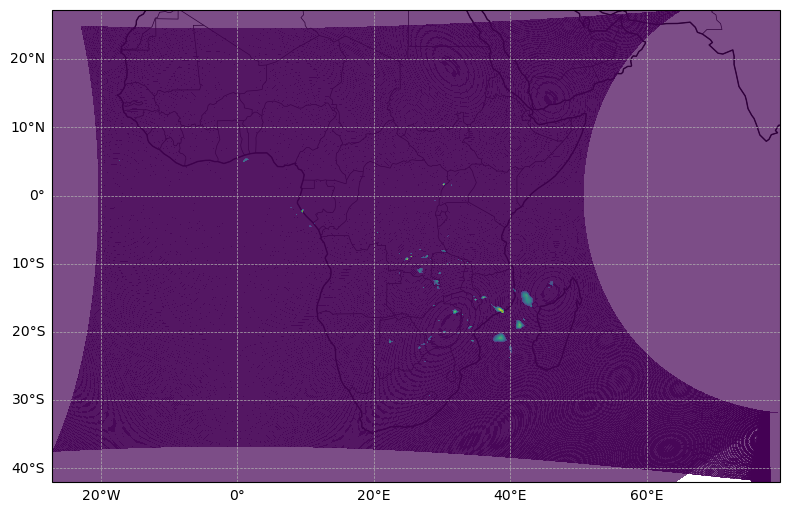

In [28]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

extent = (
    np.nanmin(filtered_lons),
    np.nanmax(filtered_lons),
    np.nanmin(filtered_lats),
    np.nanmax(filtered_lats),    
)

ax.set_extent(extent, crs=ccrs.PlateCarree())


# Base features
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='none', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m', category='cultural', name=shapename)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=1, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False

contour_core = ax.pcolormesh(
    lons, lats, cores,
    transform=ccrs.PlateCarree(),
    alpha=0.7,
    zorder=2
)
plt.tight_layout()
plt.show()

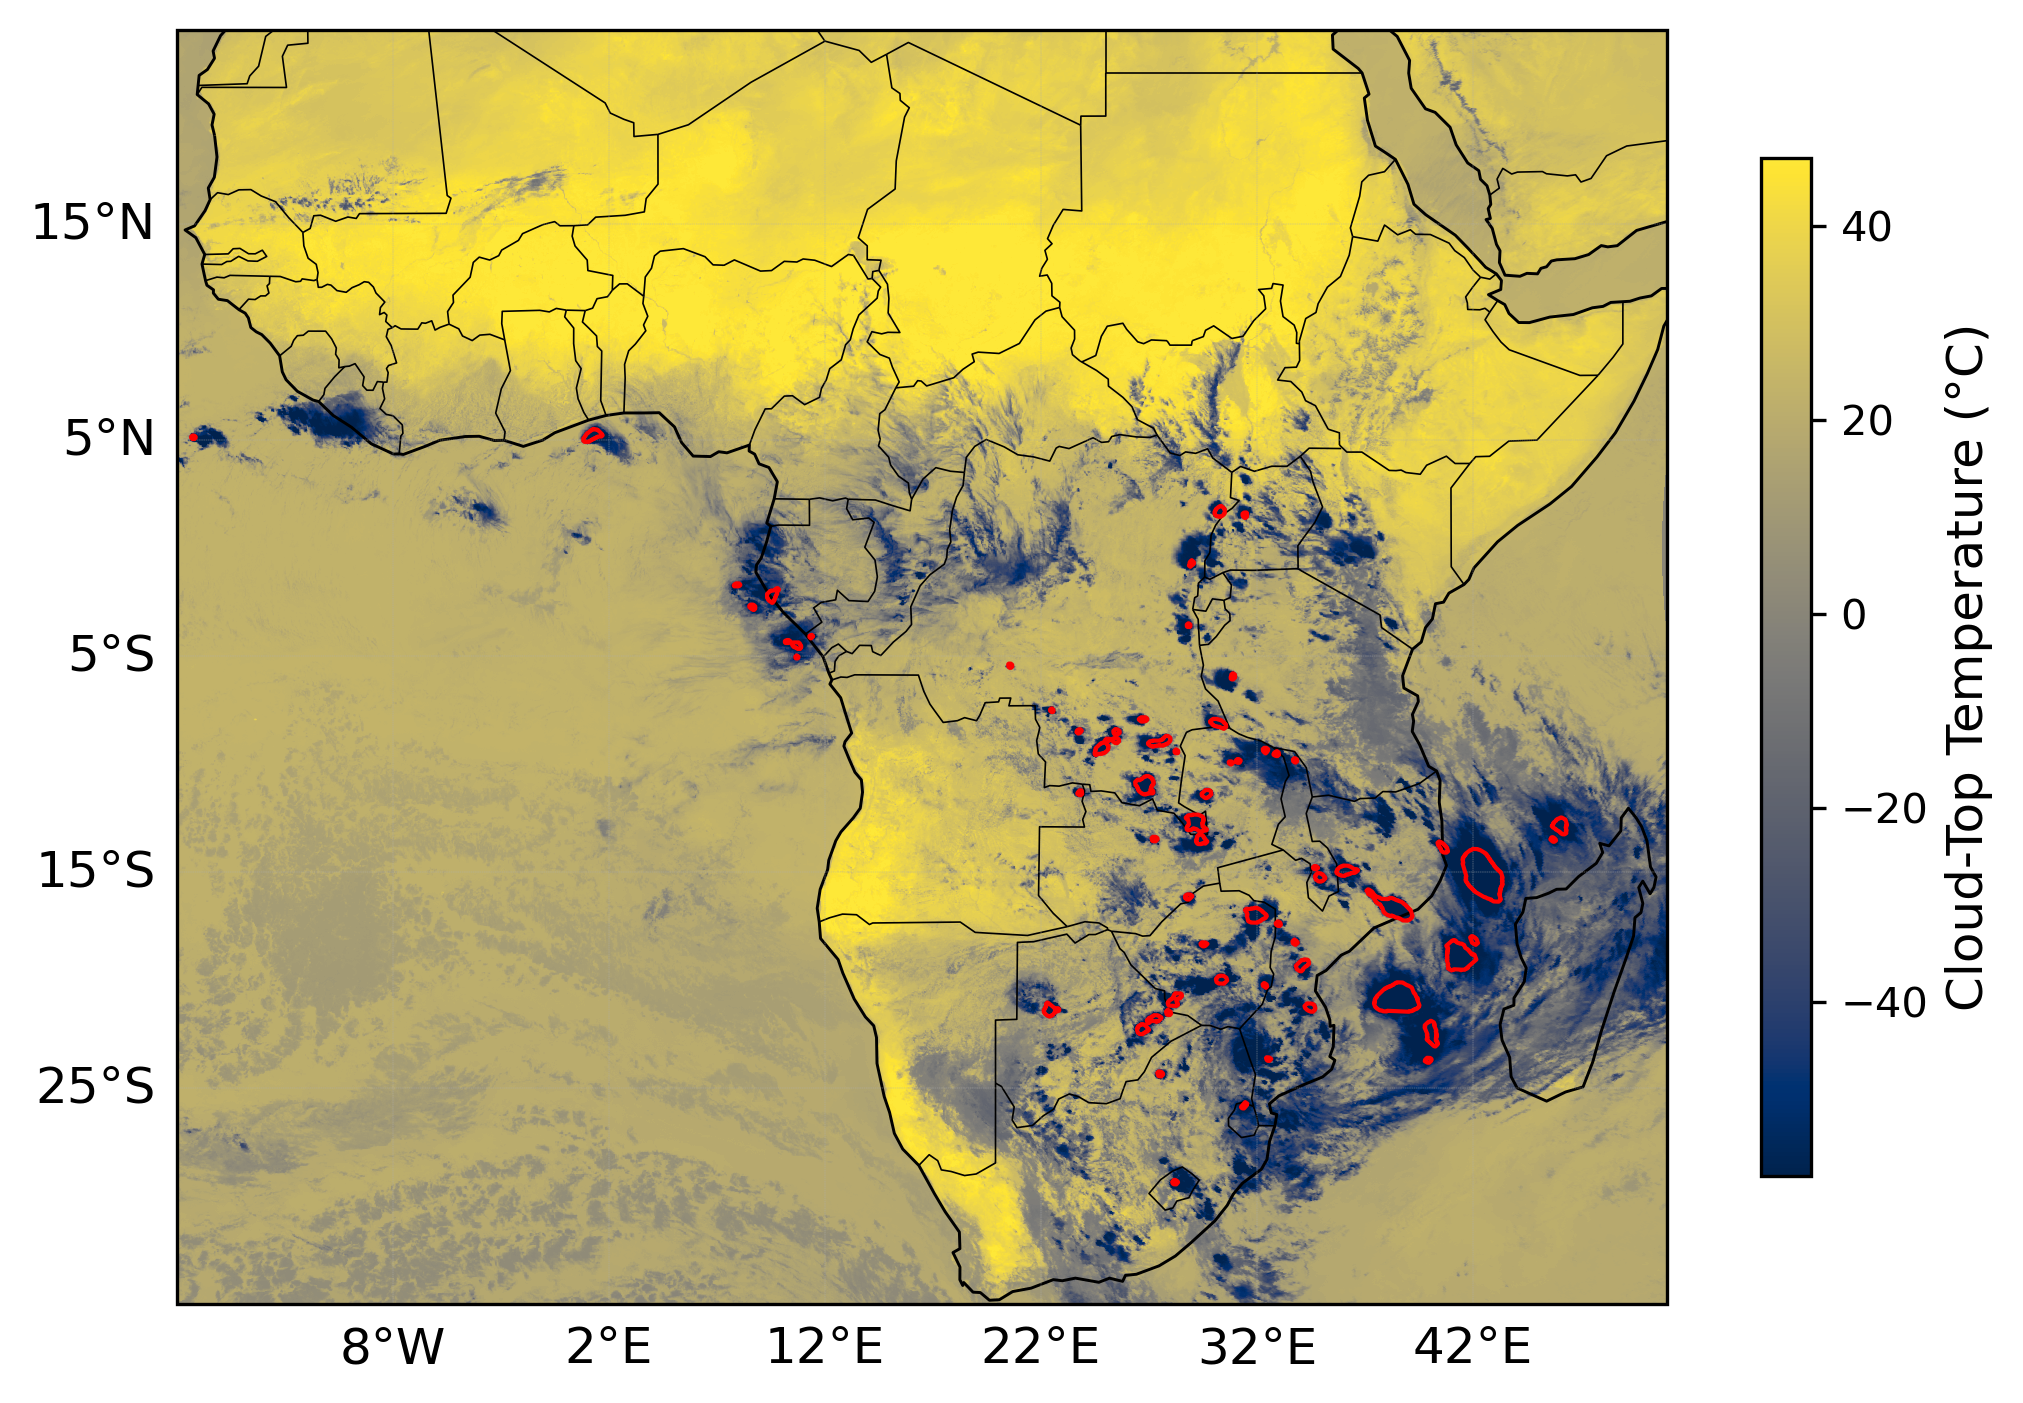

In [29]:
fig = plt.figure(figsize=(7, 10), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())

extent = (-18, 51, -35, 24)

ax.set_extent(extent, crs=ccrs.PlateCarree())

# base map
ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="none")
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

# gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1, 
                    xlocs=np.arange(round(extent[0]), round(extent[1]), 10),
                    ylocs=np.arange(round(extent[-2]), round(extent[-1]), 10)
                    )

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}

# CTT background
p = ax.pcolormesh(
    lons,
    lats,
    temp,
    cmap="cividis",
    vmin=np.nanpercentile(temp, 1),
    vmax=np.nanpercentile(temp, 97),
    shading="auto",
    zorder=1,
)

# cores as cyan contours
ax.contour(
    lons,
    lats,
    cores,
    levels=[0.5],
    colors="red",
    linewidths=1.0,
    zorder=3,
)

cb = plt.colorbar(p, ax=ax, shrink=0.35)
cb.set_label("Cloud-Top Temperature (°C)", fontsize=12)

plt.tight_layout()
plt.show()

In [35]:
import numpy as np

LAT_MIN = -35
LAT_MAX = 24
LON_MIN = -18
LON_MAX = 51

out_dir = "/home/users/mendrika/Object-Based-LSTMConv/notebooks/model/deploy/geolocation"

# load training geolocation (reference grid)
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][:, :]
lats = geodata["lat"][:, :]

# convert missing to NaN TEMPORARILY for masking
lats_nan = np.where(lats == -999.999, np.nan, lats)
lons_nan = np.where(lons == -999.999, np.nan, lons)

# Africa mask
mask = (
    (lats_nan >= LAT_MIN) &
    (lats_nan <= LAT_MAX) &
    (lons_nan >= LON_MIN) &
    (lons_nan <= LON_MAX)
)

# bounding box
rows = np.where(mask.any(axis=1))[0]
cols = np.where(mask.any(axis=0))[0]

row_min, row_max = rows[0], rows[-1]
col_min, col_max = cols[0], cols[-1]

# crop
lats_crop = lats_nan[row_min:row_max+1, col_min:col_max+1]
lons_crop = lons_nan[row_min:row_max+1, col_min:col_max+1]

# convert BACK to portal-required missing value
lats_crop = np.where(np.isnan(lats_crop), -999.999, lats_crop)
lons_crop = np.where(np.isnan(lons_crop), -999.999, lons_crop)

# save portal geolocation grids
np.save(f"{out_dir}/pancast_lats_africa.npy", lats_crop)
np.save(f"{out_dir}/pancast_lons_africa.npy", lons_crop)

print("Saved portal geolocation grids:", lats_crop.shape)

Saved portal geolocation grids: (2015, 2187)


In [38]:
np.max(lats_crop)

26.57356

In [36]:
print(row_min, row_max, col_min, col_max)

48 2062 81 2267


In [ ]:
np.nanmax(lons_crop)

79.549774

In [ ]:
np.nanmin(lats_crop)

-39.91001

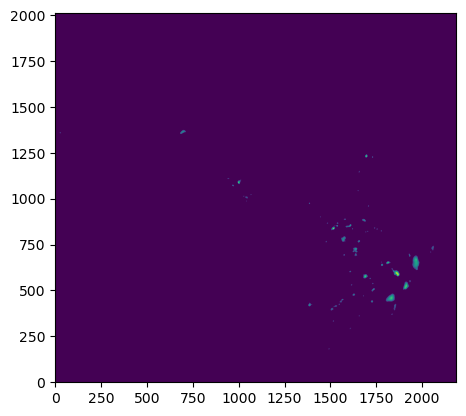

In [ ]:
plt.imshow(core_crop, origin="lower")

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

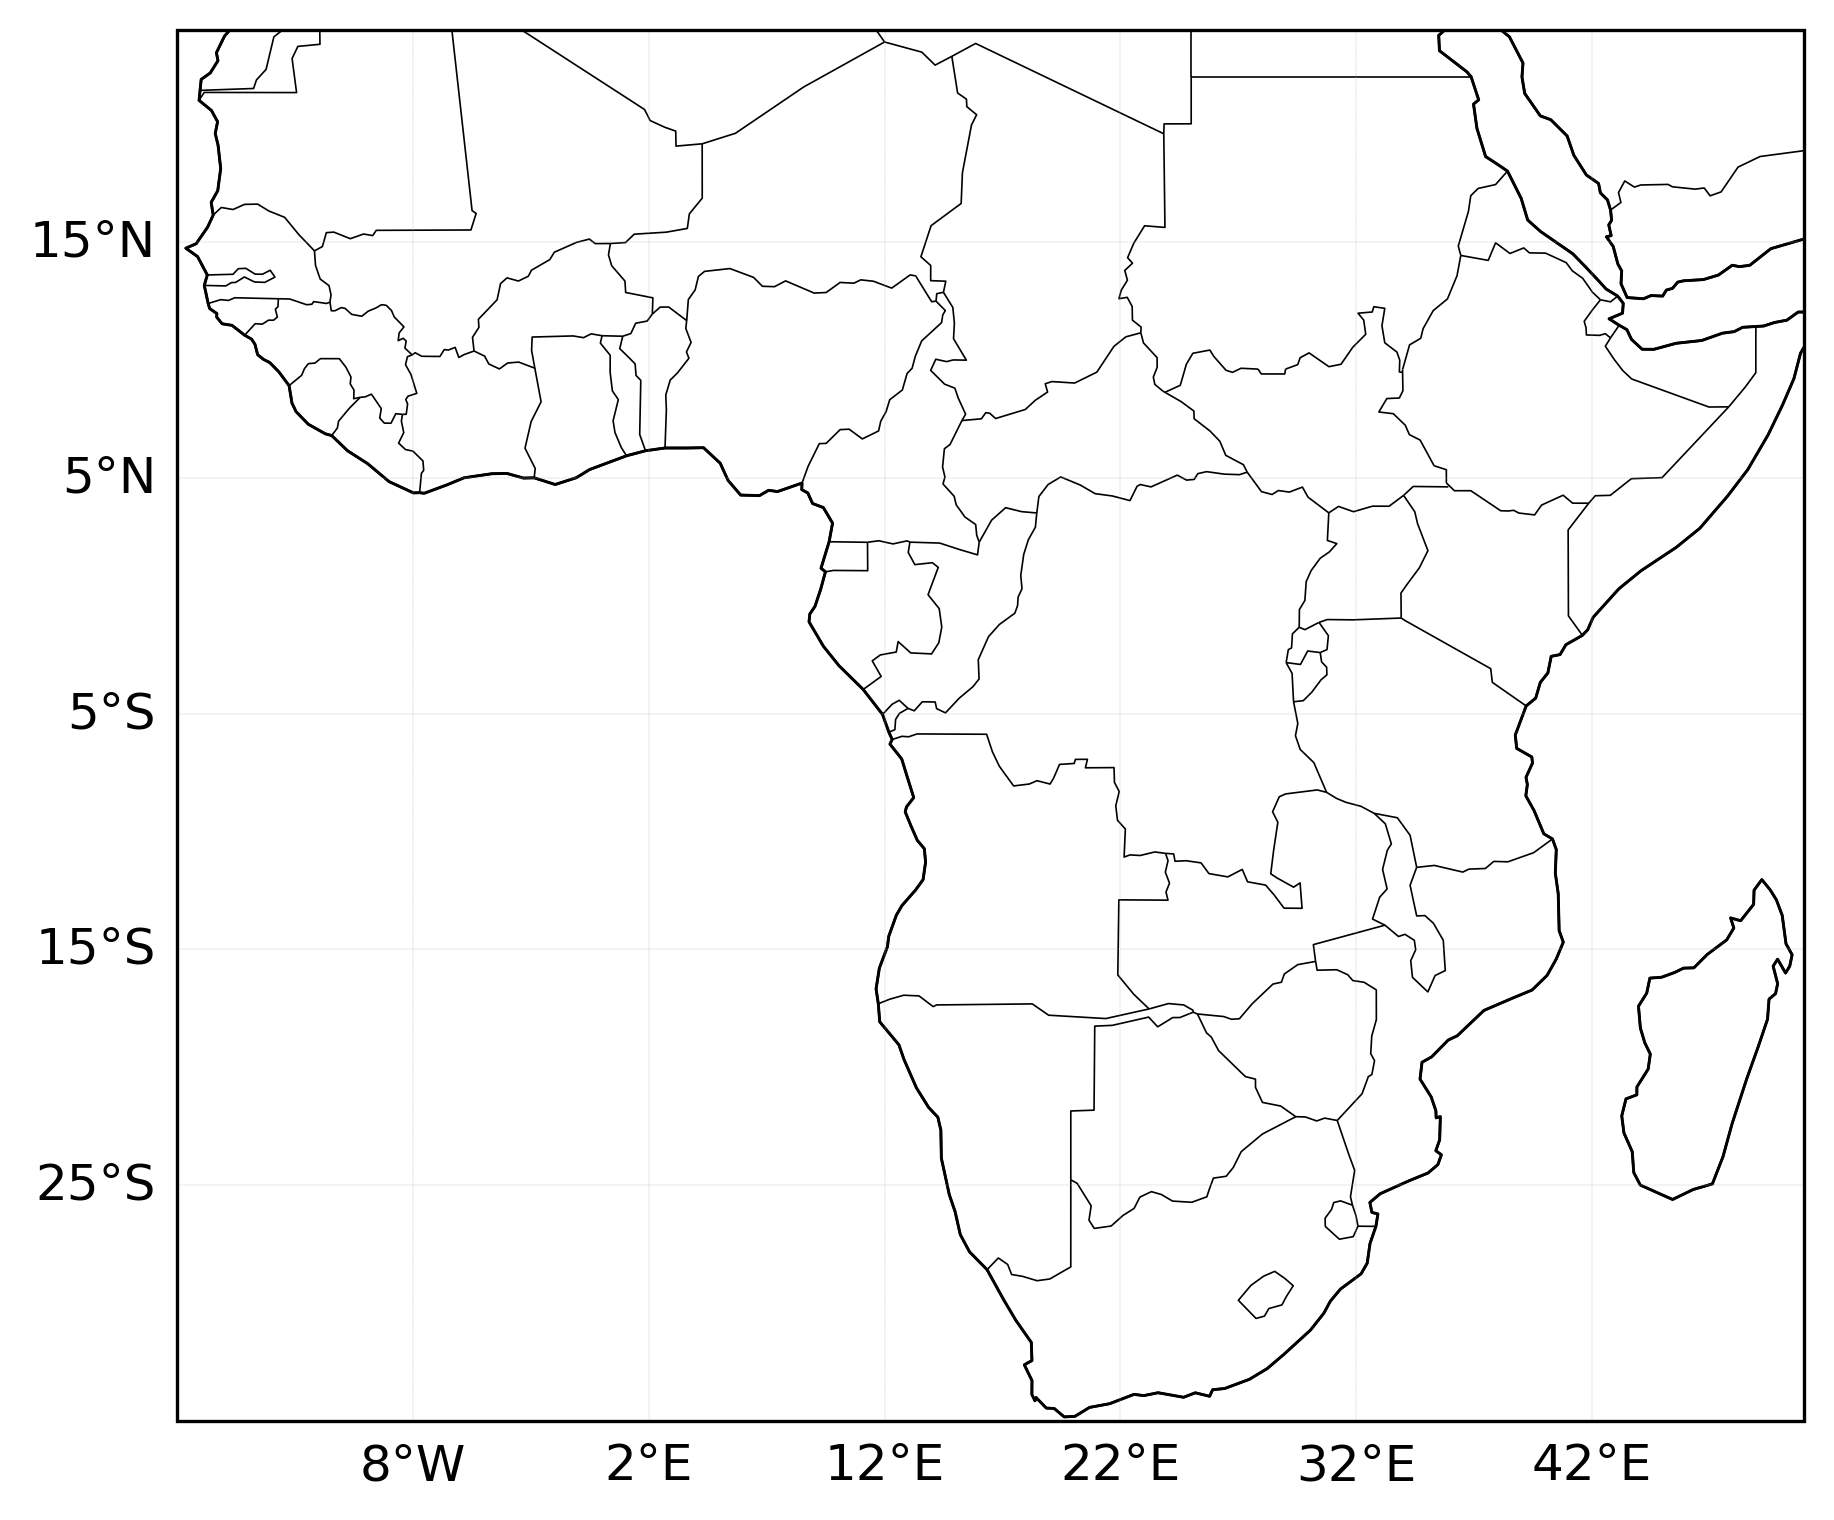

In [ ]:
fig = plt.figure(figsize=(7, 10), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())

extent = (-18, 51, -35, 24)

ax.set_extent(extent, crs=ccrs.PlateCarree())

# base map
ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="none")
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

# gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1, 
                    xlocs=np.arange(round(extent[0]), round(extent[1]), 10),
                    ylocs=np.arange(round(extent[-2]), round(extent[-1]), 10)
                    )

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}

# CTT background
p = ax.pcolormesh(
    lons,
    lats,
    temp,
    cmap="cividis",
    vmin=np.nanpercentile(temp, 1),
    vmax=np.nanpercentile(temp, 97),
    shading="auto",
    zorder=1,
)

# cores as cyan contours
ax.contour(
    lons_crop,
    lats_crop,
    core_crop,
    levels=[0.5],
    colors="red",
    linewidths=1.0,
    zorder=3,
)

cb = plt.colorbar(p, ax=ax, shrink=0.35)
cb.set_label("Cloud-Top Temperature (°C)", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics # type: ignore

In [ ]:
YEAR = "2005"

DATA_PATH = "/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/"
OUTPUT_FOLDER = "/work/scratch-nopw2/mendrika/pancast/raw"

all_files = [
    file for file in snflics.all_files_in(DATA_PATH)
    if snflics.get_time(file)["year"] == YEAR
]
all_files.sort()

# Lags in minutes: from t0-2h to t0, every 30 minutes
lag_before_t = [120, 90, 60, 30, 0]


print("YEAR =", YEAR)
print("Total files found:", len(all_files))


YEAR = 2005
Total files found: 34309


In [ ]:
CONTEXT_LAT_MIN = np.nanmin(lats_crop)
CONTEXT_LAT_MAX = np.nanmax(lats_crop)
CONTEXT_LON_MIN = np.nanmin(lons_crop)
CONTEXT_LON_MAX = np.nanmax(lons_crop)


In [ ]:
print(CONTEXT_LON_MIN, CONTEXT_LON_MAX, CONTEXT_LAT_MIN, CONTEXT_LAT_MAX)

-23.102037 79.549774 -39.91001 26.57356


In [ ]:
extent = (-18, 51, -35, 24)
